In [40]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Preprocessing 

In [ ]:
df = pd.read_csv('loan_data.csv')
original_df = df

In [ ]:
df.head()

### About data
- Loan_ID: A unique loan ID.
- Gender: Either male or female.
- Married: Weather Married(yes) or Not Marttied(No).
- Dependents: Number of persons depending on the client.
- Education: Applicant Education(Graduate or Undergraduate).
- Self_Employed: Self-employed (Yes/No).
- ApplicantIncome: Applicant income.
- CoapplicantIncome: Co-applicant income.
- LoanAmount: Loan amount in thousands.
- Loan_Amount_Term: Terms of the loan in months.
- Credit_History: Credit history meets guidelines.
- Property_Area: Applicants are living either Urban, Semi-Urban or Rural.
- Loan_Status: Loan approved (Y/N).

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.columns

In [ ]:
df.shape

In [ ]:
df.isna().sum()

In [ ]:
df.duplicated().sum()

In [ ]:
categorical_columns = [cols for cols in df.columns if df[cols].nunique() <= 5 and df[cols].dtype == object]
categorical_columns.remove('Loan_Status')

In [ ]:
for cols in df.columns:
    if df[cols].dtype != object and df[cols].nunique() > 3 and df[cols].isna().sum() > 0:
        df[cols] = df[cols].fillna(df[cols].mean())

    if df[cols].dtype != object and df[cols].isna().sum() > 0:
        df[cols] = df[cols].fillna(list(df[cols].mode())[0])

    if df[cols].dtype == object and df[cols].isna().sum() > 0:
        df[cols] = df[cols].fillna(list(df[cols].mode())[0])

In [ ]:
df.info()

In [ ]:
one_hot_encoded_PA = pd.get_dummies(df['Property_Area'])
one_hot_encoded_D = pd.get_dummies(df['Dependents'],'Dependents')
df = df.join(one_hot_encoded_PA)
df = df.join(one_hot_encoded_D)
df = df.drop(['Property_Area', 'Dependents'], axis=1)

In [ ]:
for cols in df.columns:
    if df[cols].dtype == object and df[cols].nunique() == 2 :
        labels = df[cols].unique()
        print(f"{labels} == {[1, 0]}")
        df[cols] = df[cols].replace(list(labels), [1, 0])

    if df[cols].dtype == bool:
        df[cols] = df[cols].astype(int)

In [ ]:
df['Loan_ID'] = df['Loan_ID'].apply(lambda str : int(str[3:]))

In [ ]:
binary_columns = [column for column in df.columns if df[column].nunique() == 2 and set(df[column].unique()) == set([0, 1])]
continuous_columns = [cols for cols in df.columns if cols not in binary_columns]
continuous_columns.remove('Loan_ID')

In [ ]:
print(binary_columns)
print(continuous_columns)
print(categorical_columns)

# Exploaratory Data Analysis

In [ ]:
plt.figure(figsize=(6,4))

sns.countplot(x=df['Loan_Status'])
plt.title('Barplot of Loan Status')
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Loan_Status'])
plt.title('Boxplot of Loan Status')
plt.show()

shows loan rejection is not a very rare phenomenon 

In [ ]:
plt.figure(figsize=(6,4))
sns.kdeplot(x=df['Loan_Status'])
plt.xlabel('Loan_Status')
plt.show()

In [ ]:
correlation_matrix = df.corr()
correlation_with_loan_status = correlation_matrix['Loan_Status']
continuous_columns_correlation = correlation_matrix.abs()

# # correlation of the continuous features
# print(continuous_columns_correlation)

f, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(continuous_columns_correlation, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .4}, annot=True)
plt.show()

- i can kinda draw the inference that loan_status is heavily correlated or associated with credit history but i also know that credit history is heavily skewed also it is a categorical data. 
- we can see how the one hot encoded features are correlated to some extent which is obvious
- there is a relation bw married and 0 dependants which is kinda weird
- also a small correlation between married and gender which i don't know why

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i in range(len(continuous_columns)):
    row = i // 2
    col = i % 2

    sns.boxplot(x=df[continuous_columns[i]], ax=axs[row, col])

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i in range(len(continuous_columns)):
    row = i // 2
    col = i % 2

    sns.histplot(x=df[continuous_columns[i]], ax=axs[row, col])

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

for i in range(len(categorical_columns)):
    row = i // 3
    col = i % 3

    sns.barplot(original_df[categorical_columns[i]], ax=axs[row, col])

plt.tight_layout()
plt.show()

In [ ]:
# plt.figure(figsize=(15, 10))
# sns.pairplot(df, hue='Loan_Status', palette='husl')
# plt.show()

# not so great because of the categorical features

In [ ]:
plt.figure(figsize=(15, 10))
sns.pairplot(original_df, hue='Loan_Status', palette='husl')
plt.show()

In [ ]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()

X_train = X_train.drop('Loan_ID', axis=1)
X_test = X_test.drop('Loan_ID', axis=1)
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = scaler.transform(X_test[continuous_columns]) # we just transform because we dont want the model to learn from this test data

we can use something like a param_grid to find the best parameters for the model but we can use pipepline to do this for us where we can give it all the models and it will output the best model for us

# Model Selection

### Logistic Regression Model

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['None', 'l1', 'l2', 'elasticnet'], 'solver': ['liblinear', 'saga']}

LR_grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
LR_grid.fit(X_train, y_train)

print(LR_grid.best_params_)
LR_pred = LR_grid.predict(X_test)

accuracy = metrics.accuracy_score(y_test, LR_pred)
precision = metrics.precision_score(y_test, LR_pred)
recall = metrics.recall_score(y_test, LR_pred)
f1 = metrics.f1_score(y_test, LR_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

fpr, tpr, _ = metrics.roc_curve(y_test, LR_pred)
roc_auc = metrics.auc(fpr, tpr)

precision, recall, _ = metrics.precision_recall_curve(y_test, LR_pred)
pr_auc = metrics.auc(recall, precision)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall chart')
plt.legend(loc="lower right")
plt.show()

### Naive Bayes Model

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

gnb_pred = gnb.predict(X_test)

accuracy = metrics.accuracy_score(y_test, gnb_pred)
precision = metrics.precision_score(y_test, gnb_pred)
recall = metrics.recall_score(y_test, gnb_pred)
f1 = metrics.f1_score(y_test, gnb_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

fpr, tpr, _ = metrics.roc_curve(y_test, gnb_pred)
roc_auc = metrics.auc(fpr, tpr)

precision, recall, _ = metrics.precision_recall_curve(y_test, gnb_pred)
pr_auc = metrics.auc(recall, precision)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall chart')
plt.legend(loc="lower right")
plt.show()

### SVM

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

SVM_grid = GridSearchCV(SVC(), param_grid, cv=5)
SVM_grid.fit(X_train, y_train)

print(SVM_grid.best_params_)
SVM_pred = SVM_grid.predict(X_test)

accuracy = metrics.accuracy_score(y_test, SVM_pred)
precision = metrics.precision_score(y_test, SVM_pred)
recall = metrics.recall_score(y_test, SVM_pred)
f1 = metrics.f1_score(y_test, SVM_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

fpr, tpr, _ = metrics.roc_curve(y_test, SVM_pred)
roc_auc = metrics.auc(fpr, tpr)

precision, recall, _ = metrics.precision_recall_curve(y_test, SVM_pred)
pr_auc = metrics.auc(recall, precision)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall chart')
plt.legend(loc="lower right")
plt.show()

### Random Forests

In [ ]:
param_grid = {'n_estimators': [10, 100, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 100, 1000], 'criterion': ['gini', 'entropy']}

RF_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
RF_grid.fit(X_train, y_train)

print(RF_grid.best_params_)
RF_pred = RF_grid.predict(X_test)

accuracy = metrics.accuracy_score(y_test, RF_pred)
precision = metrics.precision_score(y_test, RF_pred)
recall = metrics.recall_score(y_test, RF_pred)
f1 = metrics.f1_score(y_test, RF_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

fpr, tpr, _ = metrics.roc_curve(y_test, RF_pred)
roc_auc = metrics.auc(fpr, tpr)

precision, recall, _ = metrics.precision_recall_curve(y_test, RF_pred)
pr_auc = metrics.auc(recall, precision)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall chart')
plt.legend(loc="lower right")
plt.show()

### XGBoost Classifier

{'learning_rate': 1, 'max_depth': 10, 'n_estimators': 1000}
Accuracy: 0.7402597402597403
Precision: 0.5238095238095238
Recall: 0.5238095238095238
F1: 0.5238095238095238


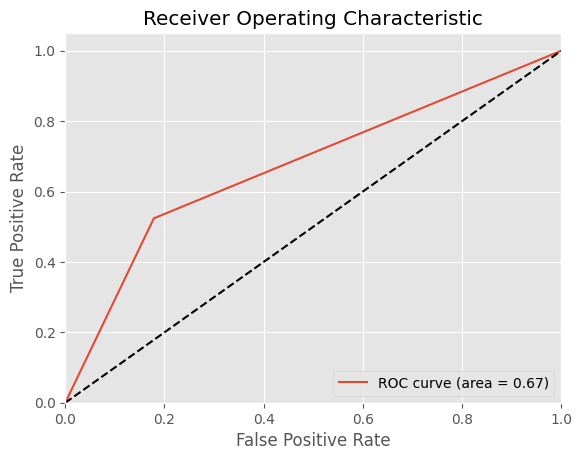

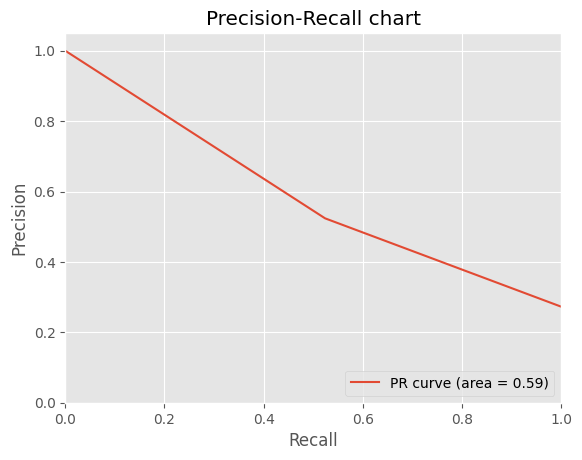

In [41]:
param_grid = {'n_estimators': [10, 100, 1000], 'learning_rate': [0.001, 0.01, 0.1, 1], 'max_depth': [10, 100, 1000]}

XGB_grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5)
XGB_grid.fit(X_train, y_train)

print(XGB_grid.best_params_)
XGB_pred = XGB_grid.predict(X_test)

accuracy = metrics.accuracy_score(y_test, XGB_pred)
precision = metrics.precision_score(y_test, XGB_pred)
recall = metrics.recall_score(y_test, XGB_pred)
f1 = metrics.f1_score(y_test, XGB_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

fpr, tpr, _ = metrics.roc_curve(y_test, XGB_pred)
roc_auc = metrics.auc(fpr, tpr)

precision, recall, _ = metrics.precision_recall_curve(y_test, XGB_pred)
pr_auc = metrics.auc(recall, precision)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall chart')
plt.legend(loc="lower right")
plt.show()